In [181]:
# import module
import os
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import cv2
import random as rn
from tensorflow import keras
from keras import layers
from keras.utils import to_categorical
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelEncoder
from tqdm import tqdm

100%|███████████████████████████████████████████████████████████████████████████████| 784/784 [00:01<00:00, 471.80it/s]


4317


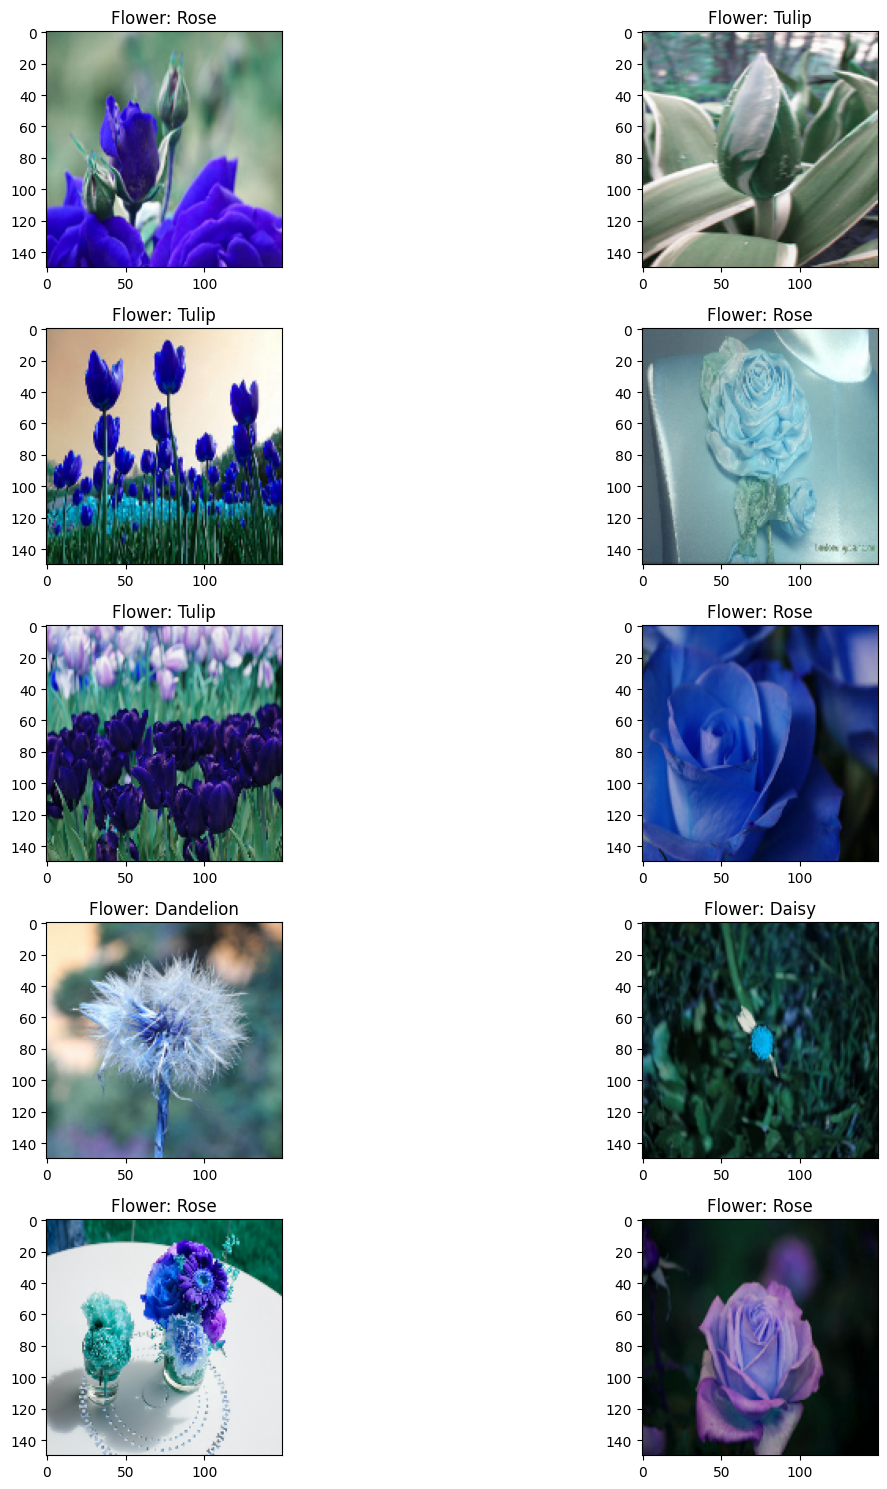

In [86]:
X = []
Z = []
IMG_SIZE = 150

# 設定資料夾相對路徑
FLOWER_DAISY_DIR = 'flowers/daisy'
FLOWER_SUNFLOWER_DIR = 'flowers/sunflower'
FLOWER_TULIP_DIR = 'flowers/tulip'
FLOWER_DANDI_DIR = 'flowers/dandelion'
FLOWER_ROSE_DIR = 'flowers/rose'


# 取得標籤
def assign_label(img,flower_type):
    return flower_type

# 從影像中取得訓練和驗證集
def make_train_data(flower_type,DIR):
    for img in tqdm(os.listdir(DIR)):
        label = assign_label(img,flower_type)
        path = os.path.join(DIR,img)
        img = cv2.imread(path,cv2.IMREAD_COLOR)
        img = cv2.resize(img, (IMG_SIZE,IMG_SIZE))
        
        X.append(np.array(img))
        Z.append(str(label))
          
make_train_data('Daisy',FLOWER_DAISY_DIR)
make_train_data('Sunflower',FLOWER_SUNFLOWER_DIR)
make_train_data('Tulip',FLOWER_TULIP_DIR)
make_train_data('Dandelion',FLOWER_DANDI_DIR)
make_train_data('Rose',FLOWER_ROSE_DIR)
print(len(X))

# 隨機顯示10張照片及標籤
fig,ax = plt.subplots(5,2)
fig.set_size_inches(15,15)
for i in range(5):
    for j in range (2):
        l = rn.randint(0,len(Z))
        ax[i,j].imshow(X[l])
        ax[i,j].set_title('Flower: '+Z[l])
        
plt.tight_layout()


In [95]:
# 資料前處理:將影像標準化及標籤做One-hot Encoding
le = LabelEncoder()
Y = le.fit_transform(Z)
Y = to_categorical(Y,5)
X = np.array(X)
X = X/255

# 分割成訓練集和驗證集
x_train,x_test,y_train,y_test = train_test_split(X,Y,train_size = 0.7,random_state = 42)

In [22]:
# 使用 ImageDataGenerator 進行影像前處理
datagenerator = ImageDataGenerator(
    featurewise_center = False,  # 把輸入資料均值設為0
    samplewise_center = False,  # 把樣本平均值設為0
    featurewise_std_normalization = False,  # 把輸入除以資料標準差
    samplewise_std_normalization = False,  # 把每個輸入除以其標準差
    zca_whitening = False,  # 不允許ZCA白化
    rotation_range = 10,  # 隨機旋轉影像
    zoom_range = 0.1, # 隨機縮放影像 
    width_shift_range = 0.2,  # 隨機水平平移影像
    height_shift_range = 0.2,  # 隨機垂直平移影像
    horizontal_flip = True,  # 隨機水平翻轉影像
    vertical_flip = False )  # 隨機垂直翻轉影像

# 將 datagenerator 用於 x_train 上
datagenerator.fit(x_train)

In [32]:
# 設定網路模型架構
inputs = keras.Input(shape = (150,150, 3))
x = layers.Conv2D(32, (5, 5),padding = 'same', activation = 'relu')(inputs)
x = layers.MaxPool2D()(x)
x = layers.Conv2D(64, (3, 3),padding = 'same', activation = 'relu')(x)
x = layers.MaxPool2D()(x)
x = layers.Conv2D(128, (3, 3),padding = 'same', activation = 'relu')(x)
x = layers.MaxPool2D()(x)
x = layers.Conv2D(128, (3, 3),padding = 'same', activation = 'relu')(x)
x = layers.MaxPool2D()(x)
x = layers.Flatten()(x)
x = layers.Dense(512, activation = 'relu')(x)
outputs = layers.Dense(5, activation = 'softmax')(x)

# 建立網路模型(將輸入到輸出所有經過的網路層連接起來)
model = keras.Model(inputs, outputs, name = 'model')

# 設定訓練使用的優化器、損失函數和指標函數
model.compile(optimizer = keras.optimizers.Adam(learning_rate=0.001),loss = 'categorical_crossentropy',metrics = ['accuracy'])

# 顯示網路架構
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 conv2d_16 (Conv2D)          (None, 150, 150, 32)      2432      
                                                                 
 max_pooling2d_16 (MaxPoolin  (None, 75, 75, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_17 (Conv2D)          (None, 75, 75, 64)        18496     
                                                                 
 max_pooling2d_17 (MaxPoolin  (None, 37, 37, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_18 (Conv2D)          (None, 37, 37, 128)       73856 

In [33]:
# 訓練網路模型
history = model.fit(datagenerator.flow(x_train,y_train),epochs=50,batch_size=128,validation_data = (x_test,y_test))

Epoch 1/50
95/95 [==============================] - 60s 605ms/step - loss: 1.4022 - accuracy: 0.3701 - val_loss: 1.1874 - val_accuracy: 0.4630
Epoch 2/50
95/95 [==============================] - 56s 576ms/step - loss: 1.1452 - accuracy: 0.5210 - val_loss: 1.0242 - val_accuracy: 0.5795
Epoch 3/50
95/95 [==============================] - 54s 553ms/step - loss: 1.0298 - accuracy: 0.5962 - val_loss: 0.9605 - val_accuracy: 0.6173
Epoch 4/50
95/95 [==============================] - 52s 534ms/step - loss: 0.9715 - accuracy: 0.6220 - val_loss: 0.9026 - val_accuracy: 0.6443
Epoch 5/50
95/95 [==============================] - 52s 528ms/step - loss: 0.9074 - accuracy: 0.6518 - val_loss: 0.8010 - val_accuracy: 0.6844
Epoch 6/50
95/95 [==============================] - 52s 526ms/step - loss: 0.8585 - accuracy: 0.6643 - val_loss: 0.7930 - val_accuracy: 0.6914
Epoch 7/50
95/95 [==============================] - 52s 525ms/step - loss: 0.8636 - accuracy: 0.6700 - val_loss: 0.8387 - val_accuracy: 0.6674

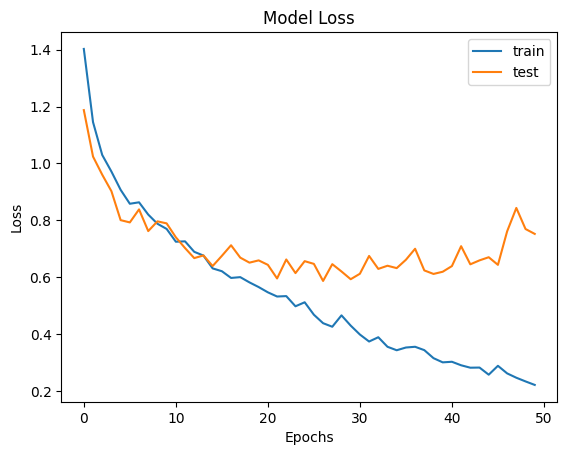

In [34]:
# 透過loss曲線評估模型
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['train', 'test'])
plt.show()

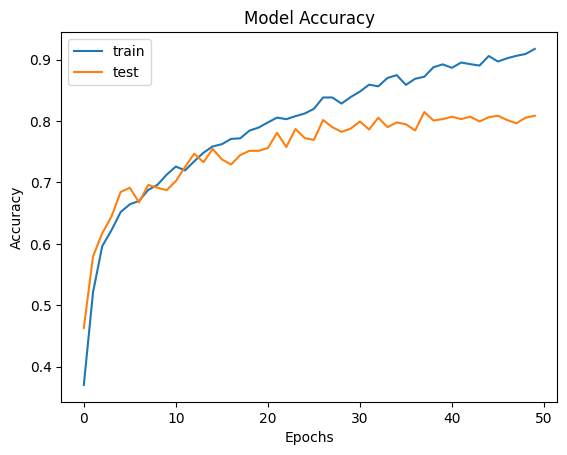

In [35]:
# 透過accuracy曲線評估模型
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['train', 'test'])
plt.show()

In [147]:
# 預測樣本屬於每個類別的機率
predict = model.predict(x_test)
y_pred = np.argmax(predict,axis=1)

41/41 [==============================] - 7s 109ms/step


In [169]:
# 在y_test隨機取10筆資料
i = 0
random_class = []
for i in range(len(y_test)):
    random_class.append(np.random.randint(len(y_test)))
    if(len(random_class) == 10):
        break
print(random_class)

[897, 894, 35, 487, 1030, 1074, 179, 672, 935, 1040]


In [183]:
random_y_test = []
random_y_pred = []
# 將隨機取的10筆資料加入要做混淆矩陣運算的陣列
for i in range(10):
    random_y_test.append(y_test[random_class[i]])
    random_y_pred.append(y_pred[random_class[i]])
# 混淆矩陣不支援one-hot encoding，所以把 random_y_test 轉換成單個數字
random_y_test_arg = np.argmax(random_y_test,axis=1)
# 做混淆矩陣運算
cm = confusion_matrix(random_y_test_arg,random_y_pred)
# 計算fp、fn、tp、tn
fp = cm.sum(axis=0) - np.diag(cm)  
fn = cm.sum(axis=1) - np.diag(cm)
tp = np.diag(cm)
tn = cm.sum() - (fp + fn + tp)
# 計算accuracy、precision、recall、f1-score
accuracy = (tp+tn)/(tp+fp+fn+tn)
precision = tp/(tp+fp)
recall = tp/(tp+fn)
f1 = (2*precision*recall)/(precision+recall)

In [184]:
# 把計算的accuracy、precision、recall、f1-score分別存進不同花卉的dictionary
daisy_dict = {}
sunflower_dict = {}
tulip_dict = {}
dandelion_dict = {}
rose_dict = {}
for i in range(5):
    if i == 0:
        daisy_dict["accuracy"] = accuracy[i]
        daisy_dict["precision"] = precision[i]
        daisy_dict["recall"] = recall[i]
        daisy_dict["f1"] = f1[i]
    elif i == 1:
        sunflower_dict["accuracy"] = accuracy[i]
        sunflower_dict["precision"] = precision[i]
        sunflower_dict["recall"] = recall[i]
        sunflower_dict["f1"] = f1[i]
    elif i == 2:
        tulip_dict["accuracy"] = accuracy[i]
        tulip_dict["precision"] = precision[i]
        tulip_dict["recall"] = recall[i]
        tulip_dict["f1"] = f1[i]
    elif i == 3:
        dandelion_dict["accuracy"] = accuracy[i]
        dandelion_dict["precision"] = precision[i]
        dandelion_dict["recall"] = recall[i]
        dandelion_dict["f1"] = f1[i]
    else:
        rose_dict["accuracy"] = accuracy[i]
        rose_dict["precision"] = precision[i]
        rose_dict["recall"] = recall[i]
        rose_dict["f1-score"] = f1[i]
print("daisy:",daisy_dict)
print("sunflower:",sunflower_dict)
print("tulip:",tulip_dict)
print("dandelion:",dandelion_dict)
print("rose:",rose_dict)

daisy: {'accuracy': 1.0, 'precision': 1.0, 'recall': 1.0, 'f1': 1.0}
sunflower: {'accuracy': 0.9, 'precision': 0.75, 'recall': 1.0, 'f1': 0.8571428571428571}
tulip: {'accuracy': 1.0, 'precision': 1.0, 'recall': 1.0, 'f1': 1.0}
dandelion: {'accuracy': 0.9, 'precision': 1.0, 'recall': 0.6666666666666666, 'f1': 0.8}
rose: {'accuracy': 1.0, 'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0}


In [172]:
# 查看以混淆矩陣算出的accuracy、precision、recall、f1-score是否與 classification_report 一致
print(classification_report(random_y_test_arg, random_y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         1
           1       0.75      1.00      0.86         3
           2       1.00      1.00      1.00         1
           3       1.00      0.67      0.80         3
           4       1.00      1.00      1.00         2

    accuracy                           0.90        10
   macro avg       0.95      0.93      0.93        10
weighted avg       0.93      0.90      0.90        10



1296 1296


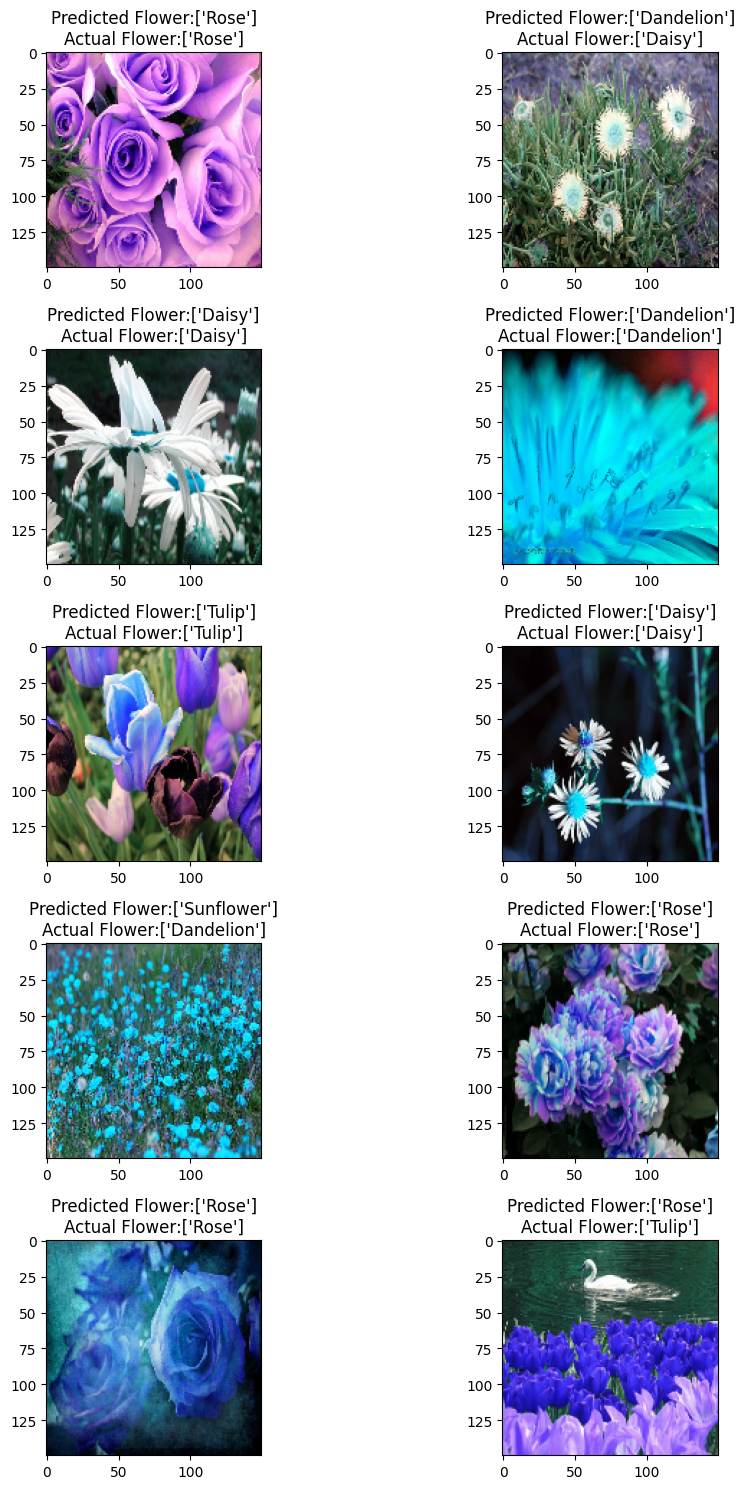

In [150]:
# 將隨機取樣的預測及正解可視化
count = 0
fig,ax = plt.subplots(5,2)
fig.set_size_inches(15,15)
print(len(predict_class),len(y_test))
for i in range (5):
    for j in range (2):
        ax[i,j].imshow(x_test[random_class[count]])
        ax[i,j].set_title("Predicted Flower:" + str(le.inverse_transform([y_pred[random_class[count]]])) + "\n" + "Actual Flower:" + str(le.inverse_transform([np.argmax([y_test[random_class[count]]])])))
        plt.tight_layout()
        count = count + 1